In [19]:
import os,re, time, pickle, collections, importlib, datetime, torch, nltk, pandas as pd, numpy as np, time
from chardet import detect
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict, Counter
from wordebd import WORDEBD
from vocab import Vocab, Vectors
from munch import Munch
from cnnlstmseq import CNNLSTMseq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from transformers import BertModel, BertTokenizer
import transformers
from torch.utils.data import DataLoader, TensorDataset, Dataset
from model import batch_graphify, MaskedEdgeAttention, MaskedNLLLoss, LSTMModel
from model import DATASET_PATH
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import random
import networkx as nx
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Make sure to specify which dataset to use
- dataset_original
- dataset_drop_noise
- dataset_smote

In [20]:
# dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"
dataset_path = DATASET_PATH
key=False

In [18]:
len(y_train_tmp)

6955

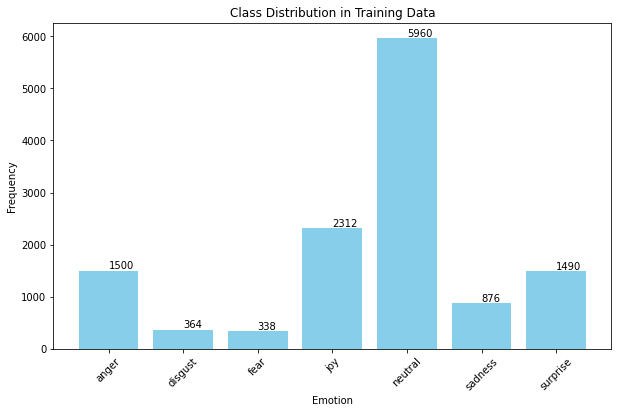

In [21]:
file = open('data/dump/' + dataset_path + '/labels_train.pkl', 'rb')
y_train_tmp = pickle.load(file)

y_train_series = pd.Series(y_train_tmp)
y_train_decoded = y_train_series.map(labelDecoder)
class_counts = y_train_decoded.value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')

# Annotate the bar chart with the frequency values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

plt.title('Class Distribution in Training Data')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [3]:
def get_encoding_type(file):
    with open(file, 'rb') as f:
        rawdata = f.read()
    return detect(rawdata)['encoding']

def detect_misspelling(source):
    pass

def replace_spelling(source):
    return re.sub("", "", source)

In [4]:
def preprocess_text(data):
    '''
    Preprocess text data
    @param data: list of text examples
    @return preprocessed_data: list of preprocessed text examples
    '''
    preprocessed_data = []
    for example in data:
        # Convert to lowercase
#         example = example.lower()
        # Remove punctuation
        example = re.sub(r'[^\w\s]', '\'', example)
        preprocessed_data.append(example)
    return preprocessed_data

def load_pretrained_glove():
    print("Loading GloVe...")
    glv_vector = {}
    f = open('/embed/glove/glove.840B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float')
        try:
            glv_vector[word] = coefs
        except ValueError:
            continue
    f.close()
    start_time = time.time()
    print(f"Took {time.time() - start_time} seconds to load pretrained GloVe model.")
    return glv_vector

def encode_labels(encoder, l):
    return encoder[l]

def _read_words(data, convmode=None):
    '''    
    Count the occurrences of all words
    @param convmode: str, None for non conversational scope, 'naive' for classic or naive approach, 'conv' for conversation depth into account (one additional dim and nested values)
    @param data: list of examples
    @return words: list of words (with duplicates)
    '''    
    words = []
    if convmode is None:
        for example in data:
            words += example.split()
    return words

def find_value_ranges(lst):
    value_ranges = []
    start_index = 0

    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            value_ranges.append((start_index, i - 1))
            start_index = i

    # Add the last range
    value_ranges.append((start_index, len(lst) - 1))

    return value_ranges

In [5]:
# Read the CSV file

if dataset_path == "dataset_drop_noise":
    X_train = pd.read_csv('data/' + dataset_path + '/X_train.csv', encoding='shift_jis')
    X_test = pd.read_csv('data/' + dataset_path+ '/X_test.csv', encoding='utf-8')
    X_dev = pd.read_csv('data/' + dataset_path + '/X_dev.csv', encoding='utf-8')
else:
    X_train = pd.read_csv('data/' + dataset_path + '/train_sent_emo_dya.csv', encoding='shift_jis')
    X_test = pd.read_csv('data/' + dataset_path+ '/test_sent_emo_dya.csv', encoding='utf-8')
    X_dev = pd.read_csv('data/' + dataset_path + '/dev_sent_emo_dya.csv', encoding='utf-8')
# Display the first three rows
print(X_train.shape)
print(X_test.shape)
print(X_dev.shape)

(12840, 12)
(3400, 12)
(1462, 12)


In [6]:
def showFreqTurns(X_set):
    utterance_counts = X_set.groupby('Dialogue_ID')['Utterance_ID'].count()
    freq_table = Counter(utterance_counts)
    max_x = 15
    freq_table_combined = {i: 0 for i in range(max_x + 1)}
    outlier_count = 0

    for key, value in freq_table.items():
        if key <= max_x:
            freq_table_combined[key] += value
        else:
            outlier_count += value

    # Add outlier count
    freq_table_combined[f'>{max_x}'] = outlier_count

    # Step 3: Plot the frequency table
    x = list(map(str, freq_table_combined.keys()))  # Convert keys to strings
    y = list(freq_table_combined.values())

    plt.bar(x, y)
    plt.xlabel('Number of Utterances in a Dialogue')
    plt.ylabel('Frequency')
    plt.title('Frequency Distribution of Utterances per Dialogue')
    plt.show()

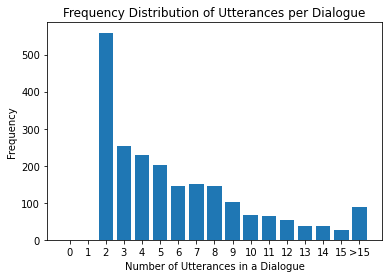

In [7]:
showFreqTurns(X_train)

In [8]:
rangesTrain = find_value_ranges(X_train["Dialogue_ID"])
print(len(rangesTrain))

rangesTest = find_value_ranges(X_test["Dialogue_ID"])
print(len(rangesTest))

rangesDev = find_value_ranges(X_dev["Dialogue_ID"])
print(len(rangesDev))

2160
577
270


In [9]:
# Define features to drop
drop_features = list(X_train.columns[6:]) 

# Create DataFrame for target labels
y_train = pd.DataFrame()
y_test = pd.DataFrame()
y_dev = pd.DataFrame()

y_train["Emotion"] = X_train["Emotion"].copy()
y_test["Emotion"] = X_test["Emotion"].copy()
y_dev["Emotion"] = X_dev["Emotion"].copy()

y_train["Dialogue_ID"] = X_train["Dialogue_ID"].copy()
y_test["Dialogue_ID"] = X_test["Dialogue_ID"].copy()
y_dev["Dialogue_ID"] = X_dev["Dialogue_ID"].copy()

# Drop features from X_train DataFrame
X_train = X_train.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)
X_dev = X_dev.drop(drop_features, axis=1)

Before spelling correction

In [10]:
# X_train[["Utterance", "Emotion"]][:50]

In [11]:
# X_test[["Utterance", "Emotion"]][:50]

In [12]:
# X_train["Utterance"] = X_train["Utterance"].apply(lambda x: replace_spelling(x))
# X_test["Utterance"] = X_test["Utterance"].apply(lambda x: replace_spelling(x))

# X_train["Utterance"] = preprocess_text(X_train["Utterance"].tolist())
# X_test["Utterance"] = preprocess_text(X_test["Utterance"].tolist())

In [13]:
def removeInstanceTurn1(X_set, Y_set, ranges):
    mask = [True] * len(X_set)  # Initialize a mask with all True values
    
    for range_pair in ranges:
        i = range_pair[0]
        j = range_pair[1]
        
        if i == j:
            mask[i] = False  # Mark the row for deletion
            print(f"Index to remove: {i}, Current X_set length: {len(X_set)}")

    # Convert mask to a numpy array for easy boolean indexing
    mask = np.array(mask)
    
    # Use the mask to filter out rows to keep
    X_set = X_set[mask]
    Y_set = Y_set[mask]
    
    # Reset index after filtering rows
    X_set.reset_index(drop=True, inplace=True)
    Y_set.reset_index(drop=True, inplace=True)
    
    return X_set, Y_set

def removeInstanceTurnLessThan6(X_set, Y_set, ranges):
    mask = [True] * len(X_set)  # Initialize a mask with all True values
    
    for range_pair in ranges:
        i = range_pair[0]
        j = range_pair[1]
        
        if (j - i + 1) < 6:  # Check if the dialogue has fewer than 6 turns
            for k in range(i, j + 1):
                mask[k] = False  # Mark the row for deletion

    # Convert mask to a numpy array for easy boolean indexing
    mask = np.array(mask)
    
    # Use the mask to filter out rows to keep
    X_set = X_set[mask]
    Y_set = Y_set[mask]
    
    # Reset index after filtering rows
    X_set.reset_index(drop=True, inplace=True)
    Y_set.reset_index(drop=True, inplace=True)
    
    return X_set, Y_set

def removeInstanceTurnMoreThan5(X_set, Y_set, ranges):
    mask = [True] * len(X_set)  # Initialize a mask with all True values
    
    for range_pair in ranges:
        i = range_pair[0]
        j = range_pair[1]
        
        if (j - i + 1) > 5:  # Check if the dialogue has more than 5 turns
            for k in range(i, j + 1):
                mask[k] = False  # Mark the row for deletion

    # Convert mask to a numpy array for easy boolean indexing
    mask = np.array(mask)
    
    # Use the mask to filter out rows to keep
    X_set = X_set[mask]
    Y_set = Y_set[mask]
    
    # Reset index after filtering rows
    X_set.reset_index(drop=True, inplace=True)
    Y_set.reset_index(drop=True, inplace=True)
    
    return X_set, Y_set

if dataset_path == "dataset_drop_noise":
    X_train, y_train = removeInstanceTurn1(X_train, y_train, rangesTrain)
    X_test, y_test = removeInstanceTurn1(X_test, y_test, rangesTest)
    X_dev, y_dev = removeInstanceTurn1(X_dev, y_dev, rangesDev)

if dataset_path == "dataset_drop_short_graphs":
    X_train, y_train = removeInstanceTurnLessThan6(X_train, y_train, rangesTrain)
    X_test, y_test = removeInstanceTurnLessThan6(X_test, y_test, rangesTest)
    X_dev, y_dev = removeInstanceTurnLessThan6(X_dev, y_dev, rangesDev)

if dataset_path == "dataset_drop_long_graphs":
    X_train, y_train = removeInstanceTurnMoreThan5(X_train, y_train, rangesTrain)
    X_test, y_test = removeInstanceTurnMoreThan5(X_test, y_test, rangesTest)
    X_dev, y_dev = removeInstanceTurnMoreThan5(X_dev, y_dev, rangesDev)

# print("X_set_cleaned:")
# print(X_train_cleaned)
# print("\nY_set_cleaned:")
# print(Y_train_cleaned)

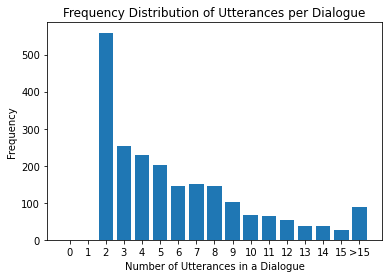

In [14]:

showFreqTurns(X_train)

In [6]:
checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/label_encoder.pkl")
checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/label_decoder.pkl")

directory_path = "data/dump/" + dataset_path
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

if not(checkFile1 and checkFile2):
    labels = sorted(set(y_train.Emotion))
    labelEncoder = {label: i for i, label in enumerate(labels)}
    labelDecoder = {i: label for i, label in enumerate(labels)}

    pickle.dump(labelEncoder, open('data/dump/' + dataset_path + '/label_encoder.pkl', 'wb'))
    pickle.dump(labelDecoder, open('data/dump/' + dataset_path + '/label_decoder.pkl', 'wb'))
else:
    file1 = open('data/dump/' + dataset_path + '/label_encoder.pkl', 'rb')
    file2 = open('data/dump/' + dataset_path + '/label_decoder.pkl', 'rb')
    labelEncoder = pickle.load(file1)
    labelDecoder = pickle.load(file2)
    file1.close()
    file2.close()

In [16]:
# Apply label encoding to the "Emotion" column in y_train
if not isinstance(y_train["Emotion"][0], np.int64):   
    y_train["Emotion"] = y_train["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))
    y_test["Emotion"] = y_test["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))
    y_dev["Emotion"] = y_dev["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))

# Copy the encoded "Emotion" column from y_train to X_train
X_train["Emotion"] = y_train["Emotion"].copy()
X_test["Emotion"] = y_test["Emotion"].copy()
X_dev["Emotion"] = y_dev["Emotion"].copy()

In [17]:
# Check if the file already exists
checkFile1 = os.path.isfile("data/dump/" + dataset_path + "/labels_train.pkl")
checkFile2 = os.path.isfile("data/dump/" + dataset_path + "/labels_test.pkl")
checkFile3 = os.path.isfile("data/dump/" + dataset_path + "/labels_dev.pkl")

if not (checkFile1 and checkFile2 and checkFile3):
    pickle.dump(X_train["Emotion"], open('data/dump/' + dataset_path + '/labels_train.pkl', 'wb'))
    pickle.dump(X_test["Emotion"], open('data/dump/' + dataset_path + '/labels_test.pkl', 'wb'))
    pickle.dump(X_dev["Emotion"], open('data/dump/' + dataset_path + '/labels_dev.pkl', 'wb'))

Creating an embedding

Testing on smaller data. Uncomment to see the size of updated representations


In [18]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)
model = transformers.BertModel.from_pretrained(model_name)

# Define your dialog data
dialogs = [
    "How are you today?",
    "I'm doing well, thank you!",
    "That's good to hear.",
    "Yes, it is.",
    "Do you have any plans for the weekend?",
    "Not really, just relaxing at home.",
    "Sounds nice.",
    "Indeed."
]

# Tokenize and encode the dialogs
encoded_dialogs = [tokenizer.encode(dialog, add_special_tokens=True) for dialog in dialogs]

# Pad sequences to the same length
max_length = max(len(dialog) for dialog in encoded_dialogs)
padded_dialogs = [dialog + [tokenizer.pad_token_id] * (max_length - len(dialog)) for dialog in encoded_dialogs]

# Create attention masks
attention_masks = [[1] * len(dialog) + [0] * (max_length - len(dialog)) for dialog in encoded_dialogs]

# Convert to PyTorch tensors
input_ids = torch.tensor(padded_dialogs)
attention_masks = torch.tensor(attention_masks)

# Obtain the BERT embeddings
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)

# Extract the contextual embeddings (CLS token)
contextual_embeddings = outputs[0][:, 0, :]  # Extract embeddings for the [CLS] token

# Print the shape of the contextual embeddings
print("Shape of contextual embeddings:", contextual_embeddings.shape)

Shape of contextual embeddings: torch.Size([8, 768])


In [19]:
# input_ids

In [20]:
# attention_masks

This is just a duplicate of code above. Using this on train data

In [21]:
rangesTrain = find_value_ranges(X_train["Dialogue_ID"])
print(len(rangesTrain))

rangesTest = find_value_ranges(X_test["Dialogue_ID"])
print(len(rangesTest))

rangesDev = find_value_ranges(X_dev["Dialogue_ID"])
print(len(rangesDev))

2160
577
270


In [22]:
X_train["Utterance"][rangesTrain[0][0]:rangesTrain[0][1]]

0     also I was the point person on my company’s tr...
1                      You must’ve had your hands full.
2                               That I did. That I did.
3         So let’s talk a little bit about your duties.
4                                My duties?  All right.
5     Now you’ll be heading a whole division, so you...
6                                                I see.
7     But there’ll be perhaps 30 people under you so...
8                                         Good to know.
9                                 We can go into detail
10                               No don’t I beg of you!
11    All right then, we’ll have a definite answer f...
12                                             Really?!
Name: Utterance, dtype: object

Testing on small sample

In [23]:
# # Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# # List of text dialogs
# dialogs = [
#     ["How are you today?", "I'm doing well, thank you!"],
#     ["That's good to hear.", "Yes, it is.", "Do you have any plans for the weekend?", "Not really, just relaxing at home."],
#     ["Sounds nice.", "Indeed."]
# ]

# # List to store contextual embeddings for each utterance
# contextual_embeddings = []

# # Iterate through each dialog
# for dialog in dialogs:
#     # Tokenize and convert dialog to input IDs
#     inputs = tokenizer(dialog, return_tensors='pt', padding=True, truncation=True)
    
#     # Get BERT model outputs
#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Extract contextual embeddings (CLS token represents the entire sequence)
#     embeddings = outputs.last_hidden_state[:, 0, :].tolist()

#     # Store embeddings for each utterance in the dialog
#     contextual_embeddings.append(embeddings)

# # Print the list of contextual embeddings
# print("List of Contextual Embeddings:")
# # for embedding in contextual_embeddings:
# #     print(embedding)

In [24]:
# # Load pre-trained BERT model and tokenizer
# model_name = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_name)
# tokenizer = BertTokenizer.from_pretrained(model_name)

# # Print model configuration
# print(model.config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



#### Contexualized train data

In [144]:
checkFile = os.path.isfile("embed/" + dataset_path + "/u_prime_BERT_train.pkl")
start_time = time.time()

if not checkFile:
    directory_path = "embed/" + dataset_path
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    dialogs = []
    for range_pair, iteration in tqdm(zip(rangesTrain, range(len(rangesTrain))), desc="Processing Ranges"):
        start_idx, end_idx = range_pair
        dialog = list(X_train['Utterance'][start_idx:end_idx + 1])
        dialogs.append(dialog)

    # List to store contextual embeddings for each utterance
    contextualEmbeddingsTrain = []

    # Iterate through each dialog
    for dialog in tqdm(dialogs, desc="Processing Dialogs"):
        # Tokenize and convert dialog to input IDs
        inputs = tokenizer(dialog, return_tensors='pt', padding=True, truncation=True)

        # Get BERT model outputs
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract contextual embeddings (CLS token represents the entire sequence)
        embeddings = outputs.last_hidden_state[:, 0, :].tolist()

        # Store embeddings for each utterance in the dialog
        contextualEmbeddingsTrain.append(torch.tensor(embeddings))

    file_path = f'embed/' + dataset_path + '/u_prime_BERT_train.pkl'
    with open(file_path, 'wb') as file:
            pickle.dump(contextualEmbeddingsTrain, file)

else:
    file_path = f'embed/' + dataset_path + '/u_prime_BERT_train.pkl'
    with open(file_path, 'rb') as file:
        contextualEmbeddingsTrain = pickle.load(file)
        
# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Contexualized train data - Elapsed time: {elapsed_time} seconds")

Processing Ranges: 918it [00:00, 61955.86it/s]
Processing Dialogs: 100%|████████████████████████████████████████████████████████████| 918/918 [05:34<00:00,  2.74it/s]


Contexualized train data - Elapsed time: 336.98226499557495 seconds


<h4> Contexualize test data

In [145]:
checkFile = os.path.isfile("embed/" + dataset_path + "/u_prime_BERT_test.pkl")
start_time = time.time()

if not checkFile:
    dialogs = []
    for range_pair in tqdm(rangesTest):
        start_idx, end_idx = range_pair            
        dialog = list(X_test['Utterance'][start_idx:end_idx + 1])
        dialogs.append(dialog)

    contextualEmbeddingsTest = []

    for dialog in tqdm(dialogs, desc="Processing Dialogs"):
        inputs = tokenizer(dialog, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].tolist()
        contextualEmbeddingsTest.append(torch.tensor(embeddings))

    file_path = f'embed/' + dataset_path + '/u_prime_BERT_test.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump(contextualEmbeddingsTest, file)

else:
    file_path = f'embed/' + dataset_path + '/u_prime_BERT_test.pkl'
    with open(file_path, 'rb') as file:
        contextualEmbeddingsTest = pickle.load(file)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Contexualized test data - Elapsed time: {elapsed_time} seconds")

Processing Dialogs: 100%|████████████████████████████████████████████████████████████| 243/243 [01:31<00:00,  2.66it/s]


Contexualized test data - Elapsed time: 93.1108500957489 seconds


<h4> Contexualize val data

In [146]:
# rangesDev

In [147]:
checkFile = os.path.isfile("embed/" + dataset_path + "/u_prime_BERT_dev.pkl")
start_time = time.time()

if not checkFile:
    dialogs = []
    for range_pair in tqdm(rangesDev):
        start_idx, end_idx = range_pair            
        dialog = list(X_dev['Utterance'][start_idx:end_idx + 1])
        dialogs.append(dialog)

    contextualEmbeddingsDev = []

    for dialog in tqdm(dialogs, desc="Processing Dialogs"):
        inputs = tokenizer(dialog, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].tolist()
        contextualEmbeddingsDev.append(torch.tensor(embeddings))

    file_path = f'embed/' + dataset_path + '/u_prime_BERT_dev.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump(contextualEmbeddingsDev, file)

else:
    file_path = f'embed/' + dataset_path + '/u_prime_BERT_dev.pkl'
    with open(file_path, 'rb') as file:
        contextualEmbeddingsDev = pickle.load(file)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Contexualized test data - Elapsed time: {elapsed_time} seconds")

Processing Dialogs: 100%|██████████████████████████████████████████████████████████████| 89/89 [00:33<00:00,  2.64it/s]

Contexualized test data - Elapsed time: 33.80242943763733 seconds


<h4> Getting speaker encoder for train set

In [148]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
encodedSpeakersTrain = []

if not checkFile:
    for range_pair in rangesTrain:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_train['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTrain.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/' + dataset_path + '/speaker_encoder_train.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTrain, rangesTrain], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb")
    encodedSpeakersTrain, rangesTrain = pickle.load(file)
    file.close()
    

C:\Users\edayo\AppData\Local\Temp\ipykernel_7708\1242819068.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_speaker = speaker_per_dialog.replace(speaker_encoder)


<h4> Getting speaker encoder for test set

In [149]:
checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_test.pkl")
encodedSpeakersTest = []

if not checkFile:
    for range_pair in rangesTest:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_test['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTest.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/' + dataset_path + '/speaker_encoder_test.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTest, rangesTest], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/' + dataset_path + '/speaker_encoder_test.pkl', "rb")
    encodedSpeakersTest, rangesTest = pickle.load(file)
    file.close()

C:\Users\edayo\AppData\Local\Temp\ipykernel_7708\1561329555.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_speaker = speaker_per_dialog.replace(speaker_encoder)


<h4> Getting speaker encoder for val set

In [150]:
checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_dev.pkl")
encodedSpeakersDev = []

if not checkFile:
    for range_pair in rangesDev:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_dev['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersDev.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/' + dataset_path + '/speaker_encoder_dev.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersDev, rangesDev], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/' + dataset_path + '/speaker_encoder_dev.pkl', "rb")
    encodedSpeakersDev, rangesDev = pickle.load(file)
    file.close()

C:\Users\edayo\AppData\Local\Temp\ipykernel_7708\2618188345.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_speaker = speaker_per_dialog.replace(speaker_encoder)


<h4>Getting data required for graph processing

In [151]:
D_m = 100
D_g = 150
D_p = 150
D_e = int(contextualEmbeddingsTrain[0].shape[1]/2)
D_h = 100
D_a = 100
graph_h=100
n_speakers=2
max_seq_len=110
window_past=0
window_future=5
# vocab_size=vocab_size
n_classes=7
listener_state=False
context_attention='general'
dropout=0.5
nodal_attention=False
no_cuda=True
n_relations = 2 * n_speakers ** 2
att_model = MaskedEdgeAttention(2 * D_e, max_seq_len, no_cuda)
nodal_attention=True
edge_type_mapping = {}
for j in range(n_speakers):
    for k in range(n_speakers):
        edge_type_mapping[str(j) + str(k) + '0'] = len(edge_type_mapping)
        edge_type_mapping[str(j) + str(k) + '1'] = len(edge_type_mapping)

Sample Experiment

In [152]:
# x_data = torch.tensor([
#                         [[1, 2, 3, 0, 0],     # Utterance 1
#                         [4, 5, 0, 0, 0]],    # Utterance 2
#                        [[6, 7, 8, 9, 0],     # Utterance 3
#                         [10, 0, 0, 0, 0]]])  # Utterance 4

# umask_data = torch.tensor([[1, 1],        # Dialogue 1 has 2 utterances
#                            [1, 0]])       # Dialogue 2 has 1 utterance
# # features = cnn_feat_extractor(x_data, umask_data)
# # emotions, hidden = lstm(features)

# textf = x_data.squeeze(0)  # Remove batch dimension (1, utterance_size, embedding_size) -> (utterance_size, embedding_size)
# umask = torch.FloatTensor([[1] * textf.size(0)])  # Adjust to (1, utterance_size)
# lengths = [(umask[j] == 1).nonzero().tolist()[-1][0] + 1 for j in range(len(umask))]

In [153]:
# print(textf)
# print(umask)
# print(lengths)

In [154]:
# encodedSpeakersTrain

June 5 possible mismatch

In [155]:
# for ranges in rangesDev:
#     if ranges[1]-ranges[0] == 0:
#         print("delete")

In [156]:
# max_seq_len = 17
# umask = torch.FloatTensor([[1] * 10 + [0] * (17 - 10)])
# assert umask.size(1) == max_seq_len, f"umask size is {umask.size(1)}, expected {max_seq_len}"
# lengths = [(umask[j] == 1).nonzero().tolist()[-1][0] + 1 for j in range(len(umask))]
# print(umask)
# print(lengths)

In [157]:
class ContextDataset(Dataset):
    def __init__(self, contextEmbeddings, rangesSet, encodedSpeakersSet):
#         print(contextEmbeddings[0])
        self.contextEmbeddings = contextEmbeddings
        self.rangesSet = rangesSet
        self.encodedSpeakersSet = encodedSpeakersSet

    def __len__(self):
        return len(self.rangesSet)

    def __getitem__(self, idx):
        startIdx, endIdx = self.rangesSet[idx]
#         sequence = self.X_set["sequence"][startIdx:endIdx+1].tolist()
        convs = self.contextEmbeddings[idx]
        qmask = self.encodedSpeakersSet[startIdx: endIdx+1]
        return convs, qmask

# Define the ContextEncoding function
def ContextEncoding(file_path, dataset):
    all_emotions, all_umask, all_seq_lengths = [], [], []
    all_features, all_edge_index, all_edge_norm, all_edge_type, all_edge_index_lengths = [], [], [], [], []
    max_seq_len = 30
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    for convs, qmask in tqdm(dataloader, desc="Encoding Progress", unit="batch"):
        convs = convs[0]
        textf = convs.unsqueeze(1)

        umask = torch.FloatTensor([[1] * len(textf) + [0] * (max_seq_len - len(textf))])
        assert umask.size(1) == max_seq_len, f"umask size is {umask.size(1)}, expected {max_seq_len}"
        lengths = [(umask[j] == 1).nonzero().tolist()[-1][0] + 1 for j in range(len(umask))]
        
        features, edge_index, \
        edge_norm, edge_type, \
        edge_index_lengths = batch_graphify(textf, 
                                            qmask,
                                            lengths,
                                            window_past,
                                            window_future,
                                            edge_type_mapping,
                                            att_model, 
                                            no_cuda)
        all_umask.append(umask)
        all_seq_lengths.append(lengths)
        all_features.append(features)
        all_edge_index.append(edge_index)
        all_edge_norm.append(edge_norm)
        all_edge_type.append(edge_type)
        all_edge_index_lengths.append(edge_index_lengths)
        
    with open(file_path, 'wb') as file:
        pickle.dump([   all_umask, \
                        all_seq_lengths,
                        all_features, \
                        all_edge_index, \
                        all_edge_norm, \
                        all_edge_type, \
                        all_edge_index_lengths], file)
    
    return all_features, all_edge_index, all_edge_norm, all_edge_type, all_edge_index_lengths


In [158]:
# File paths
file_path1 = 'embed/' + dataset_path + '/pre_h_prime_BERT_train.pkl'
file_path2 = 'embed/' + dataset_path + '/pre_h_prime_BERT_test.pkl'
file_path3 = 'embed/' + dataset_path + '/pre_h_prime_BERT_dev.pkl'

# Check if files exist
checkFile1 = os.path.isfile(file_path1)
checkFile2 = os.path.isfile(file_path2)
checkFile3 = os.path.isfile(file_path3)

if not checkFile1:
    encodedSpeakersFlat = [speaker for dialogue in encodedSpeakersTrain for speaker in dialogue]
    oheEncodedSpeakersFlat = torch.FloatTensor([[1, 0] if x == 0 else [0, 1] for x in encodedSpeakersFlat])
    trainDataset = ContextDataset(contextualEmbeddingsTrain, rangesTrain, oheEncodedSpeakersFlat)
    start_time = time.time()
    
    all_features, \
     all_edge_index, \
     all_edge_norm, \
     all_edge_type, \
     all_edge_index_lengths = ContextEncoding(file_path1, trainDataset)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode train text")

if not checkFile2:
    encodedSpeakersFlat = [speaker for dialogue in encodedSpeakersTest for speaker in dialogue]
    oheEncodedSpeakersFlat = torch.FloatTensor([[1, 0] if x == 0 else [0, 1] for x in encodedSpeakersFlat])
    
    testDataset = ContextDataset(contextualEmbeddingsTest, rangesTest, oheEncodedSpeakersFlat)
    start_time = time.time()
    testContext, _, _, _, _ = ContextEncoding(file_path2, testDataset)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode test text")
    
if not checkFile3:
    encodedSpeakersFlat = [speaker for dialogue in encodedSpeakersDev for speaker in dialogue]
    oheEncodedSpeakersFlat = torch.FloatTensor([[1, 0] if x == 0 else [0, 1] for x in encodedSpeakersFlat])
    
    devDataset = ContextDataset(contextualEmbeddingsDev, rangesDev, oheEncodedSpeakersFlat)
    start_time = time.time()
    devContext, _, _, _, _ = ContextEncoding(file_path3, devDataset)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode test text")

if checkFile1 and checkFile2 and checkFile3:
#     with open(file_path1[0], 'rb') as file1:
#         trainContext = pickle.load(file1)
    with open(file_path1, 'rb') as file1:
        _, _, features, edge_index, \
        edge_norm, edge_type, edge_index_lengths = pickle.load(file1)     
#     with open(file_path2[0], 'rb') as file2:
#         testContext = pickle.load(file2)
#     with open(file_path3[0], 'rb') as file3:
#         devContext = pickle.load(file3)

Encoding Progress: 100%|█████████████████████████████████████████████████████████| 918/918 [00:05<00:00, 170.20batch/s]


It took 6.344594240188599 seconds to encode train text


Encoding Progress: 100%|█████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 173.71batch/s]


It took 1.6044166088104248 seconds to encode test text


Encoding Progress: 100%|███████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 163.40batch/s]

It took 0.6120474338531494 seconds to encode test text


In [159]:
contextualEmbeddingsTrain[0].shape

torch.Size([14, 768])

In [160]:
print(len(contextualEmbeddingsTrain))
print(len(contextualEmbeddingsTest))
print(len(contextualEmbeddingsDev))

918
243
89


Unsupervised visualization

In [161]:
# Assuming contextual_embeddings is your list of contextual embeddings

# Flatten the list of contextual embeddings into a single list
flattened_embeddings = [emb for dialogue in contextual_embeddings for emb in dialogue]

# Convert the flattened list into a single tensor
tensor_data = torch.tensor(flattened_embeddings)

# Check the shape of the tensor
print(tensor_data.shape)

torch.Size([6144])


Distribution of labels in train data

In [162]:
# Calculate the counts for each unique label
uniqueLabelsTrain, labelCountsTrain = np.unique(list(X_train["Emotion"]), return_counts=True)

# Print the counts for each unique label
for label, count in zip(uniqueLabelsTrain, labelCountsTrain):
    print(f"{labelDecoder[label]}: {count} train occurrences")

anger: 1123 train occurrences
disgust: 251 train occurrences
fear: 244 train occurrences
joy: 1567 train occurrences
neutral: 4150 train occurrences
sadness: 654 train occurrences
surprise: 1050 train occurrences


Distribution of labels in test data

In [163]:
# Calculate the counts for each unique label
uniqueLabelsTest, labelCountsTest = np.unique(list(X_test["Emotion"]), return_counts=True)

# Print the counts for each unique label
for label, count in zip(uniqueLabelsTest, labelCountsTest):
    print(f"{labelDecoder[label]}: {count} test occurrences")

anger: 400 test occurrences
disgust: 63 test occurrences
fear: 43 test occurrences
joy: 321 test occurrences
neutral: 1095 test occurrences
sadness: 200 test occurrences
surprise: 248 test occurrences


In [164]:
#set this to true if you finish the context encoding, also manually change the file
key = False

In [165]:
def apply_label_decoder(df, columns, decoder):
    for column in columns:
        df[column] = df[column].map(decoder)
    return df

def load_and_concatenate_predictions(dataset_path):
    # Define directory path
    directory = f"data/dump/{dataset_path}/BERT_data_for_classifier"
    
    # Create directory if it does not exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Load predictions from pickle files
    file_name = f"{directory}/BERT_predictedTest.pkl"
    with open(file_name, 'rb') as file:
        df_predictions_BERT = pickle.load(file)

    file_name = f"{directory}/egat_predictedTest.pkl"
    with open(file_name, 'rb') as file:
        df_predictions_BERT_egat = pickle.load(file)

    # Concatenate DataFrames
    df_concatenated = pd.concat([
        X_test[["Utterance", "Emotion", "Dialogue_ID"]],
        df_predictions_BERT["predicted_label"].rename("BERT_predicted_label"),
        df_predictions_BERT_egat["predicted_label"].rename("EGAT_predicted_label")
    ], axis=1)

    # Apply label decoder to specified columns
    df_concatenated = apply_label_decoder(df_concatenated, ["Emotion", "BERT_predicted_label", "EGAT_predicted_label"], labelDecoder)

    # Save the DataFrame to CSV
    output_file = f"{directory}/test_predictions.csv"
    df_concatenated.to_csv(output_file, index=False)

    return df_concatenated

# Example usage:
if key:
    concatenated_df = load_and_concatenate_predictions(dataset_path)
    print(concatenated_df.head())

#### VIsualize graphs 

In [166]:
X_train = pd.read_csv('data/' + dataset_path + '/train_sent_emo_dya.csv', encoding='shift_jis')
X_test = pd.read_csv('data/' + dataset_path+ '/test_sent_emo_dya.csv', encoding='utf-8')
X_dev = pd.read_csv('data/' + dataset_path + '/dev_sent_emo_dya.csv', encoding='utf-8')

In [167]:
X_train[4017:4030]

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Old_Dialogue_ID,Old_Utterance_ID,Season,Episode,StartTime,EndTime
4017,"Ross, but me down for another box of the mint ...",Monica,neutral,neutral,686,0,336,2,3,10,"00:12:13,649","00:12:20,071"
4018,"Ah, we’re out. I sold them all.",Ross,neutral,neutral,686,1,336,3,3,10,"00:12:20,948","00:12:23,032"
4019,What?,Monica,surprise,positive,686,2,336,4,3,10,"00:12:23,534","00:12:25,076"
4020,No.,Monica,sadness,negative,686,3,336,6,3,10,"00:12:29,915","00:12:32,959"
4021,"No, just, just, just a couple more boxes.",Monica,anger,negative,686,4,336,7,3,10,"00:12:29,915","00:12:35,211"
4022,"It-it-it’s no big deal, all right, I’m-I’m cool.",Monica,fear,negative,686,5,336,8,3,10,"00:12:29,915","00:12:39,591"
4023,You gotta help me out with a couple more boxes!,Monica,sadness,negative,686,6,336,9,3,10,"00:12:33,502","00:12:44,137"
4024,"Mon, look at yourself. You have cookie on your...",Ross,disgust,negative,686,7,336,10,3,10,"00:12:45,222","00:12:47,724"
4025,Oh God!,Monica,sadness,negative,686,8,336,11,3,10,"00:12:48,184","00:12:49,225"
4026,"Okay, the other night I was leaving the museum...",Ross,joy,positive,686,9,336,15,3,10,"00:12:59,987","00:13:09,788"


In [168]:
# sampled_df['Emotion'].map(labelDecoder2)

In [169]:
print(labelDecoder)
print(labelDecoder2)

{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'neutral', 5: 'sadness', 6: 'surprise'}
{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [170]:



def visualize_combined_dialogues(dialogues_df):
    G = nx.DiGraph()
    
    # Add nodes and edges for each dialogue
    for dialogue_id in dialogues_df['Dialogue_ID'].unique():
        df = dialogues_df[dialogue_id == dialogues_df['Dialogue_ID']]
        
        # Add nodes with emotion as an attribute
        for idx, row in df.iterrows():
            G.add_node((dialogue_id, row['Utterance_ID']), emotion=row['Emotion'])
        
        # Add edges (for simplicity, connect consecutive utterances)
        for i in range(len(df) - 1):
            G.add_edge((dialogue_id, df['Utterance_ID'].iloc[i]), (dialogue_id, df['Utterance_ID'].iloc[i + 1]))
    
    pos = nx.spring_layout(G, seed=42)  # Position nodes using the spring layout
    emotions = nx.get_node_attributes(G, 'emotion')
    node_colors = [emotions[node] for node in G.nodes()]
    
    # Use a specific color map for clear differentiation
    cmap = plt.get_cmap('tab10', len(labelDecoder2))
    
    plt.figure(figsize=(14, 10))
    nx.draw(G, pos, node_color=node_colors, cmap=cmap, 
            node_size=300, 
#             with_labels=True,
            alpha=0.9)
    
    # Create a legend using labelDecoder2
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=cmap(i / len(labelDecoder2)), markersize=10) 
               for i in range(len(labelDecoder2))]
    plt.legend(handles, [labelDecoder2[i] for i in range(len(labelDecoder2))], title='Emotions', loc='best')
    
    plt.title('Combined Dialogue Graphs')
    plt.show()

if dataset_path == "dataset_original":
    sampled_dialogues = X_train['Dialogue_ID'].unique()
    MAX_G = 60
    if len(sampled_dialogues) > MAX_G:
        sampled_dialogues = random.sample(list(sampled_dialogues), MAX_G)

    sampled_df = X_train[X_train['Dialogue_ID'].isin(sampled_dialogues)]

    # Encoding emotions using custom labelEncoder2
    sampled_df['Emotion'] = sampled_df['Emotion'].map(labelEncoder2)
    # Visualize the combined dialogues
    visualize_combined_dialogues(sampled_df)

SyntaxError: expected ':' (2944104896.py, line 38)

Visualize utterance embeddnig (u') with T-SNE

In [ ]:
# labels = torch.tensor(X_train["Emotion"])

In [ ]:
# label_decoder

In [ ]:
# runTSNE = 1
# if runTSNE:
#     from sklearn.manifold import TSNE
#     import matplotlib.pyplot as plt

#     # List of perplexity values to loop over
#     perplexity_values = [50]

#     # Loop over each perplexity value
#     for perplexity in perplexity_values:
#         # Initialize t-SNE with the current perplexity value
#         tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

#         # Fit and transform the data using t-SNE
#         h_prime_tsne = tsne.fit_transform(tensor_data.detach().numpy())

#         # Plot the node embeddings with different colors for each label
#         plt.figure(figsize=(10, 8))
#         for label, emotion in zip(range(len(label_encoder)), label_encoder):
#             indices = (labels == label).nonzero().squeeze()
#             plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
#         plt.title(f'Utterance Embeddings (Train) Visualization (t-SNE) - Perplexity {perplexity}', color="white")
#         plt.xlabel('Dimension 1', color="white")
#         plt.ylabel('Dimension 2', color="white")
#         plt.legend()
#         plt.show()

 Visualize utterance embedding (u') with PCA

In [ ]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(tensor_data.detach().numpy())

# # Plot the PCA result with color-coded labels
# plt.figure(figsize=(8, 6))
# for label in np.unique(labels):
#     indices = labels == label
#     plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'{label_decoder[label]}', alpha=0.5)
#     plt.title('PCA Visualization of Utterance Embeddings (Train) with Color-Coded Labels')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend()
#     plt.grid(True)
#     plt.show()